This notebook first determines
1. the number of Eukaryotic GenBank genomes that have gene models (`CDS_from_genomic`) available for download
2. the number of Eukarytic transcriptomes in the Transcriptome Shotgun Assembly database
3. the taxonomic lineage of each Eukaryotic genome and transcripome (NCBI taxonomy)

Then, given this data, it explores the taxonomic breadth and biases in these reference sequences.

This notebook was executed on 02/27/2023. Somes cells query NCBI's FTPs or APIs to retrieve information.
These files were written out and when I re-executed the notebook, I read in these files instead of re-running the queries.

In [1]:
setwd("..")

In [5]:
library(readr)
library(dplyr, warn.conflicts = F)
library(purrr)
library(tidyr)
library(janitor, warn.conflicts = F)
library(taxize)
library(ggplot2)
library(ggforce)

## GenBank genomes with gene models

The genbank `annotation_hashes.txt` file has a columns named "Features hash" and "Proteins name hash."
When the values of either of those columns are "D41D8CD98F00B204E9800998ECF8427E", that indicates the file does not exist.

In [3]:
# don't spam NCBI and get IP blocked; delays the read_tsv function by 6 seconds
slowly_read_tsv <- slowly(read_tsv, rate = rate_delay(6))

In [4]:
# generate urls to download
genbank_url_prefix <- "https://ftp.ncbi.nlm.nih.gov/genomes/genbank/"
genbank_groups <- c("plant","fungi", "invertebrate", "protozoa", "vertebrate_mammalian", "vertebrate_other")
annotation_hashes_urls <- paste0(genbank_url_prefix, genbank_groups, "/annotation_hashes.txt")
assembly_summaries_urls <- paste0(genbank_url_prefix, genbank_groups, "/assembly_summary.txt")

In [5]:
#annotation_hashes <- read_tsv("~/Downloads/annotation_hashes.tsv", show_col_types = F)
annotation_hashes <- annotation_hashes_urls %>%
  set_names()  %>%
  map_dfr(slowly_read_tsv, show_col_types = F, .id = "genbank_group",) %>%
  clean_names() %>%
  mutate(genbank_group = gsub(genbank_url_prefix, "", genbank_group),
         genbank_group = gsub("/annotation_hashes.txt", "", genbank_group))

In [6]:
table(annotation_hashes$features_hash == "D41D8CD98F00B204E9800998ECF8427E")
table(annotation_hashes$protein_names_hash == "D41D8CD98F00B204E9800998ECF8427E")


FALSE  TRUE 
 6730 24654 


FALSE  TRUE 
 5945 25017 

In [7]:
# get metadata, including organism name, for GenBank genomes

#assembly_summaries <- read_tsv("~/Downloads/assembly_summaries.tsv", show_col_types = F) %>%
#  mutate(genbank_group = gsub("/assembly_summary.txt", "", genbank_group))

assembly_summaries <- assembly_summaries_urls %>%
  set_names() %>%
  map_dfr(slowly_read_tsv, .id = "genbank_group", skip = 1, show_col_types = F) %>%
  mutate(genbank_group = gsub(genbank_url_prefix, "", genbank_group),
         genbank_group = gsub("/assembly_summary.txt", "", genbank_group))

In [8]:
genbank_genomes <- left_join(annotation_hashes, assembly_summaries, by = c("number_assembly_accession" = "# assembly_accession", "genbank_group"))
genbank_genomes_cds <- genbank_genomes %>%
  filter(features_hash != "D41D8CD98F00B204E9800998ECF8427E")

## GenBank Eukaryotic Transcriptome Shotgun Assemblies (TSA)

Unlike above, I couldn't find a programatic way to identify all of the Eukaryotic transcriptomes in the TSA.
Instead, I navigated to this url: https://www.ncbi.nlm.nih.gov/Traces/wgs/?page=1&view=TSA and on the left hand side of the page, selected "eukaryotes." I then clicked the "download" button to retrieve metadata on all eukaryotic transcriptome assemblies. I included the downloaded file, "wgs_selector.csv", in the inputs folder, prefixed by its date.

In [9]:
tsa <- read_csv("inputs/20230227_wgs_selector.csv.gz", show_col_types = F) %>%
  clean_names() %>%
  filter(!keyword_ss %in% "TSA; Targeted") # remove targeted transcriptomes

In [10]:
nrow(tsa)

[1] 8703

In [11]:
length(unique(tsa$organism_an))

[1] 6077

In [12]:
table(unique(tsa$organism_an) %in% genbank_genomes_cds$organism_name)


FALSE  TRUE 
 5691   386 

## Retrieve taxonomic lineages for genomes and transcriptomes

In [14]:
organisms <- unique(c(unique(tsa$organism_an), unique(genbank_genomes_cds$organism_name))) %>% sort()

In [23]:
# further split to save progress...even with an entrez api key the api periodically returned errors,
# which lead to none of the results being saved in the assigned object.
tax_list1 <- taxize::classification(organisms[1:2000], db = 'ncbi')
tax_list2 <- taxize::classification(organisms[2001:4000], db = 'ncbi')
tax_list31 <- taxize::classification(organisms[4001:4500], db = 'ncbi')
tax_list32 <- taxize::classification(organisms[4501:5000], db = 'ncbi') 
tax_list33 <- taxize::classification(organisms[5001:5500], db = 'ncbi')
tax_list34 <- taxize::classification(organisms[5501:6000], db = 'ncbi') 
tax_list4 <- taxize::classification(organisms[6001:8000], db = 'ncbi')
tax_list5 <- taxize::classification(organisms[8001:length(organisms)], db = 'ncbi')

In [ ]:
tax_list <- c(tax_list1, tax_list2, tax_list31, tax_list32, tax_list33,
              tax_list34, tax_list4, tax_list5)

tax_list_na <- tax_list[is.na(tax_list)]
tax_list_filtered <- tax_list[!is.na(tax_list)]

In [ ]:
# some failed for invalid naming or having brackets in the name. 
# fix names and re-run. 
# for invalid names, run at genus level 
failed <- names(tax_list_na)
failed <- gsub("\\[", "", failed)
failed <- gsub("\\]", "", failed)
failed[18:47] <- gsub(" .*", "", failed[18:47])
failed[1] <- "Agave"
failed[2] <- "Ashbya"
failed[16] <- "Pythium"
tax_list6 <- taxize::classification(failed, db = 'ncbi')
names(tax_list6) <- names(tax_list_na)

In [ ]:
tax_list <- c(tax_list_filtered, tax_list6)
saveRDS(tax_list, "inputs/20230227_tax_list_full.RDS")

In [15]:
tax_list <- readRDS("inputs/20230227_tax_list_full.RDS")

In [16]:
tax_long <- tax_list %>%
  purrr::imap(~mutate(.x, batch = .y)) %>%
  bind_rows() %>%
  filter(rank %in% c("superkingdom", "kingdom", "phylum", "subphylum", "class", 
                     "subclass", "order", "suborder", "superfamily", "family", 
                     "genus", "species"))

In [19]:
tax_names <- tax_long %>%
  select(name, rank, batch) %>%
  pivot_wider(id_cols = batch, names_from = rank, values_from = name) %>%
  select(batch, superkingdom, kingdom, phylum, subphylum, class, subclass, 
         order, suborder, superfamily, family, genus, species)

In [20]:
tax_ids <- tax_long %>%
  select(id, rank, batch) %>%
  pivot_wider(id_cols = batch, names_from = rank, values_from = id) %>%
  select(batch, superkingdom, kingdom, phylum, subphylum, class, subclass, 
         order, suborder, superfamily, family, genus, species)

In [21]:
# output taxonomy tables
write_tsv(tax_names, "inputs/20230227_taxonomy_names.tsv.gz")
write_tsv(tax_ids, "inputs/20230227_taxonomy_ids.tsv.gz")

In [22]:
# join with transcriptome and genome tables
genbank_genomes_cds <- left_join(genbank_genomes_cds, tax_names, by = c("organism_name" = "batch"))
write_tsv(genbank_genomes_cds, "inputs/20230227_genbank_genomes_cds.tsv.gz")

In [23]:
tsa <- left_join(tsa, tax_names, by = c("organism_an" = "batch"))
write_tsv(tsa, "inputs/20230227_tsa.tsv.gz")

## Plot the breakdown of phyla that will be investigated by the pipeline

In [24]:
tsa_phylum <- tsa %>% 
  select(prefix_s, organism_an, superkingdom, kingdom, phylum, subphylum, class, 
         subclass, order, suborder, superfamily, family, genus, species) %>%
  group_by(superkingdom, kingdom, phylum) %>%
  tally() %>%
  mutate(source = "TSA transcriptome")

genbank_phylum <- genbank_genomes_cds %>%
  select(number_assembly_accession, organism_name, superkingdom, kingdom, phylum, 
         subphylum, class, subclass, order, suborder, superfamily, family, genus, species) %>%
  group_by(superkingdom, kingdom, phylum) %>%
  tally() %>%
  mutate(source = "GenBank Genome")

phylum <- bind_rows(tsa_phylum, genbank_phylum) %>%
  replace_na(list(superkingdom = "Eukaryota", kingdom = "Other", phylum = "Other")) %>%
  # order of plot is alphabetical, so hackiest of hacks to sort phylum by kingdom
  mutate(phylum = ifelse(kingdom == "Fungi", paste0("   ", phylum),
                         ifelse(kingdom == "Metazoa", paste0("  ",  phylum),
                                ifelse(kingdom == "Other", paste0(" ", phylum), phylum))))

In [26]:
# format for ggforce parallel sets
data <- ggforce::gather_set_data(phylum, 1:3)

# create a palette that recycles colors so each taxonomic label will be colorful
palette <- c( "#8DA0CB",  "#A6D854", "#FFD92F", "#E78AC3", "#E5C494", "#66C2A5", "#FC8D62", "#B3B3B3")

# otherwise ramp up from the user-defined palette
palette <- grDevices::colorRampPalette(palette)(length(unique(data$y)))

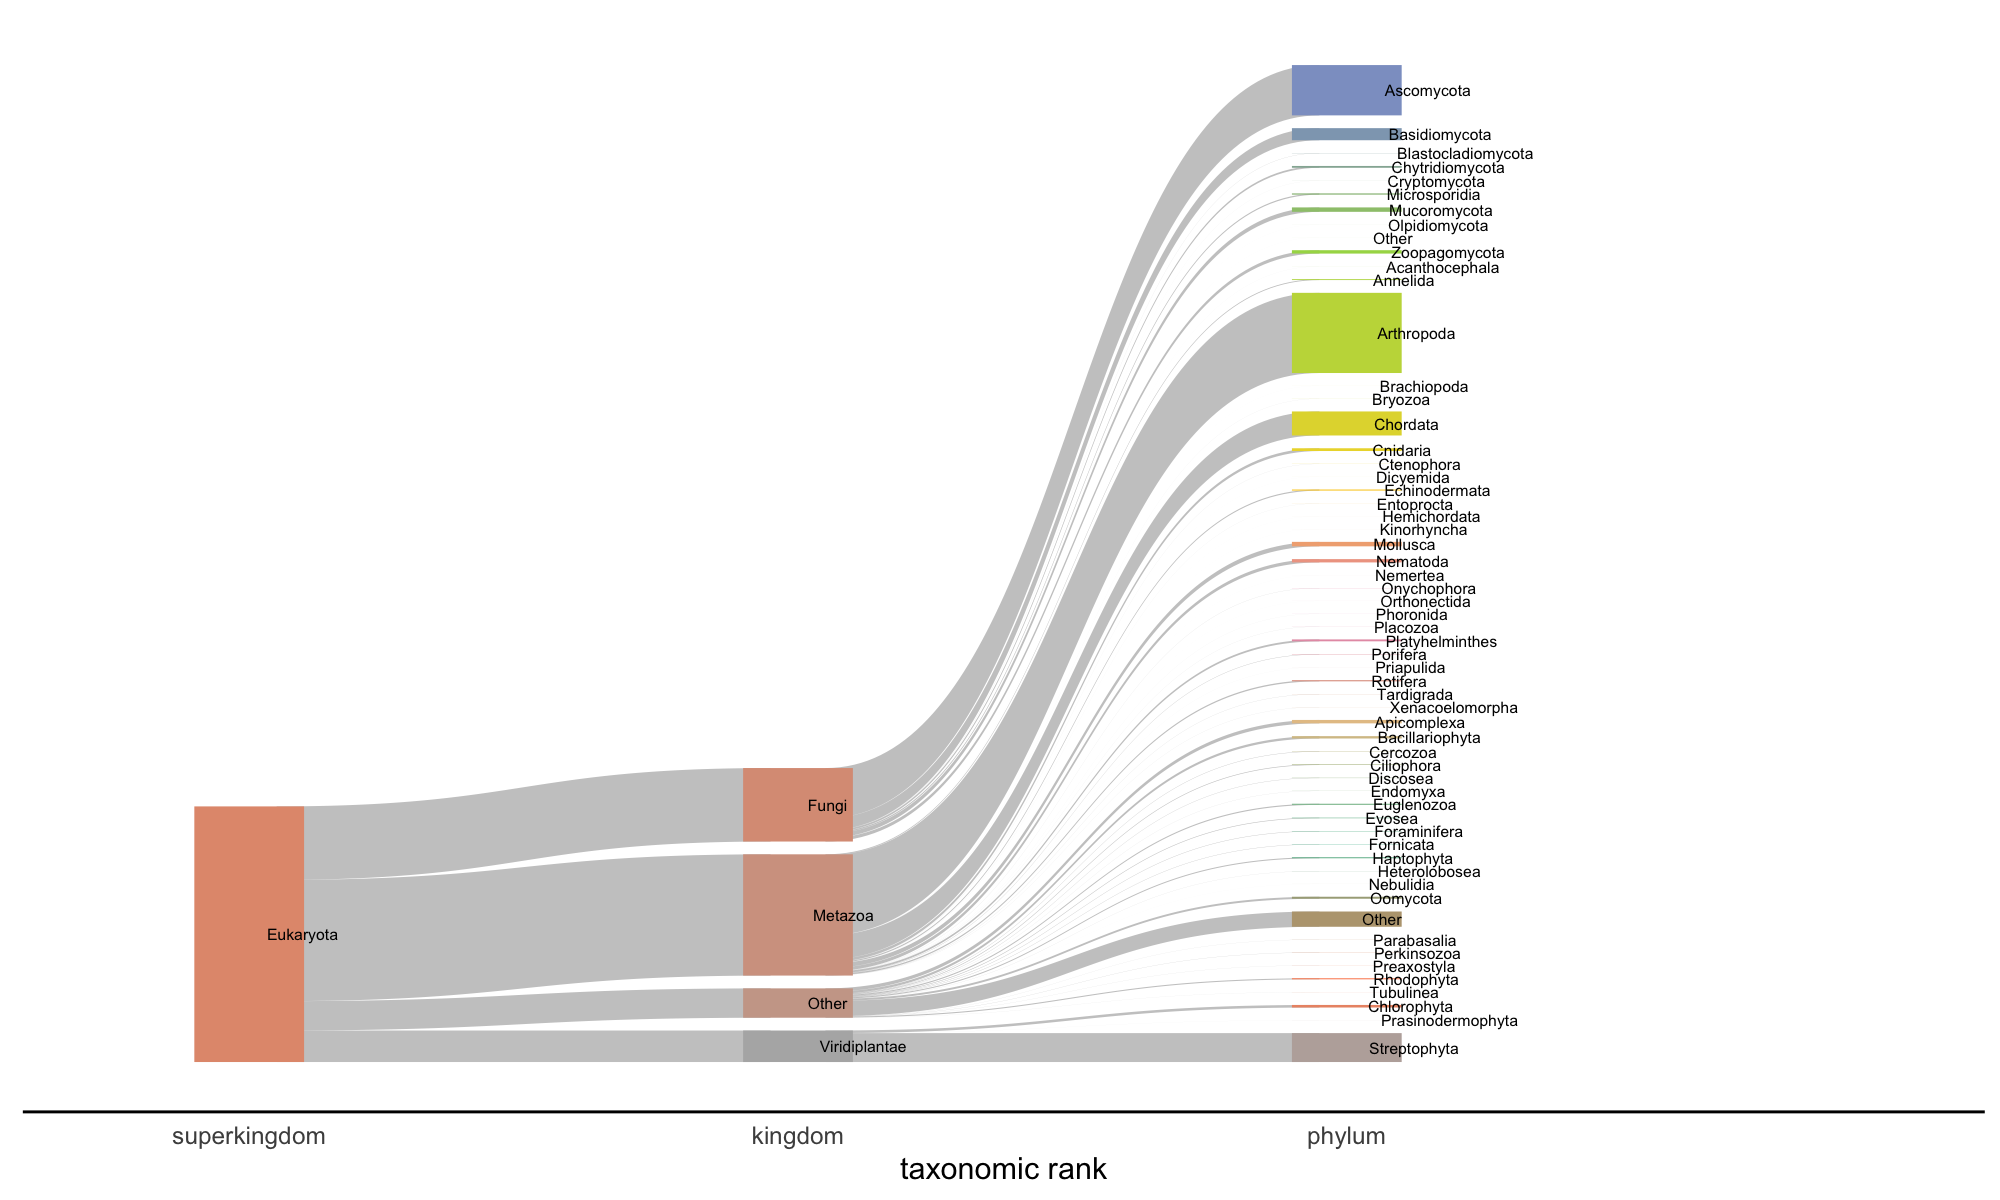

In [30]:
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 200)
sankey_plt <- ggplot2::ggplot(data, ggplot2::aes(x = .data$x, id = .data$id, split = .data$y, value = .data$n)) +
  ggforce::geom_parallel_sets(alpha = 0.3, axis.width = 0.1) +
  ggforce::geom_parallel_sets_axes(axis.width = 0.2, ggplot2::aes(fill = .data$y)) +
  ggplot2::theme_classic() +
  ggplot2::theme(axis.line.y = ggplot2::element_blank(),
                 axis.text.y = ggplot2::element_blank(),
                 axis.ticks.y = ggplot2::element_blank(),
                 axis.ticks.x = ggplot2::element_blank(),
                 legend.position = "None") +
  ggplot2::labs(x = "taxonomic rank") +
  # buffer the last axis so full names have space to print to viz
  ggplot2::scale_x_continuous(labels = c("superkingdom", "kingdom", "phylum", ""),
                              breaks = 1:4,
                              limits = c(.75, 4)) +
  ggplot2::scale_fill_manual(values = palette) +
  ggforce::geom_parallel_sets_labels(colour = 'black', angle = 360, size = 2, hjust = -0.25)
sankey_plt

In [6]:
sessionInfo()

R version 4.1.3 (2022-03-10)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur/Monterey 10.16

Matrix products: default
BLAS/LAPACK: /Users/taylorreiter/miniconda3/envs/pltenv/lib/libopenblasp-r0.3.21.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggforce_0.4.1  ggplot2_3.4.0  taxize_0.9.100 janitor_2.2.0  tidyr_1.3.0   
[6] purrr_1.0.1    dplyr_1.1.0    readr_2.1.3   

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.10       lubridate_1.9.0   ape_5.6-2         lattice_0.20-45  
 [5] zoo_1.8-11        digest_0.6.31     foreach_1.5.2     utf8_1.2.3       
 [9] IRdisplay_1.1     R6_2.5.1          plyr_1.8.8        repr_1.1.5       
[13] evaluate_0.20     pillar_1.8.1      rlang_1.0.6       curl_5.0.0       
[17] uuid_1.1-0        data.table_1.14.6 stringr_1.5.0     polyclip_1.10-4  
[21] munsell